IMPORTING MODULES AND SETTING PARAMETERS

In [100]:
%run ../modules.ipynb

sys.path.append('../0. kernel-tutorials/')
# Local Utilities for Notebook
from utilities.kernels import linear_kernel, gaussian_kernel
from utilities.general import load_variables, get_stats
from utilities.plotting import (
    plot_base, 
    plot_projection,
    plot_regression,
    plot_simple,
    get_cmaps,
    table_from_dict,
    check_mirrors,
)
cmaps = get_cmaps()
plt.style.use("../0. kernel-tutorials/utilities/kernel_pcovr.mplstyle")
dbl_fig = (2 * plt.rcParams["figure.figsize"][0], plt.rcParams["figure.figsize"][1])

kernel_params = {"kernel": "rbf", "gamma": 1}
kernel_func = partial(rbf_kernel, gamma=1)
kernel_type = "gaussian"
sns.set(style="white", palette="muted", color_codes=True)
my_c=colors.ListedColormap(["mediumblue", 'red'])
c= ["mediumblue", 'red']
sns.set_palette(sns.color_palette(c))

n_FPS=2000
n_frames=30000
n_PC=3

LOADING NPZ FILE CONTAINING SOAP VECTORS, MAGIC OR NON-MAGIC LABEL, ENERGY AND GEOMETRIC DESCRIPTORS 

In [134]:
npzfile = np.load('../datasets/MP_PCA_soap'+str(n_frames)+'.npz', allow_pickle=True)

my_frames=npzfile['my_frames']
natoms=npzfile['natoms']
magic=npzfile['magic']
e_form=npzfile['e_form'].ravel()
std_ratio=npzfile['std_ratio']
n_species=npzfile['n_species']
alpha=npzfile['alpha']
x=npzfile['x']
cn=npzfile['cn']
packing=npzfile['packing']
fcc=npzfile['fcc']
X_raw=npzfile['X_raw']
len(my_frames)

30000

In [135]:
(alpha.shape), (cn.shape), (packing.shape), (x.shape), (e_form.shape)

((30000,), (30000,), (30000,), (30000,), (30000,))

In [136]:
magic=[int(i) for i in magic]
magic=np.array(magic).reshape(-1,1)
magic.shape

(30000, 1)

In [137]:

y_magic=np.copy(magic.reshape(-1,1))
X_raw.shape, y_magic.shape, y_tot.shape

((30000, 2000), (30000, 1), (30000, 5))

In [138]:
i_train, i_test, X_train, X_test, y_train, y_test = train_test_split(
np.arange(X.shape[0]), X, y_magic, train_size=0.8
)
x_scaler = StandardFlexibleScaler(column_wise=False).fit(X)
# Center total dataset
X = x_scaler.transform(X)
# Center training data
X_train = x_scaler.transform(X_train)
# Center training data
X_test = x_scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24000, 2000), (6000, 2000), (24000, 1), (6000, 1))

LOGISTIC REGRESSION 

/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy of logistic regression model on testing set:0.6131666666666666


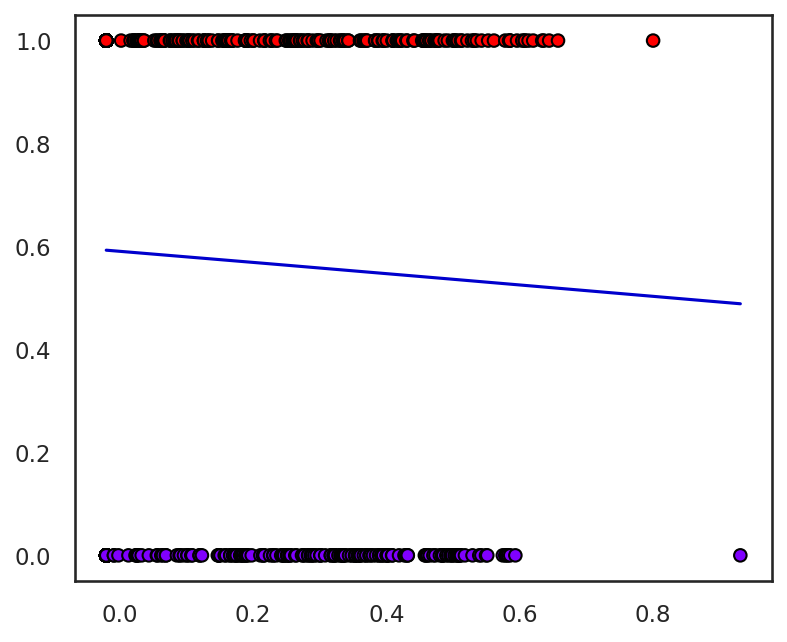

In [139]:
logr = LogisticRegression(solver='saga',  C=0.1, max_iter=1000)
logr.fit(X, y_magic)
y_pred = logr.predict(X)

prob=logr.predict_proba(X)

print('Accuracy of logistic regression model on testing set:'+str(logr.score(X_test, y_test)))


"""Looking at the sigmoid function to see how well the dots are placed"""
df = pd.DataFrame({'x': X_test[:,0].ravel(), 'y': y_test.ravel()})
df = df.sort_values(by='x')
sigmoid_function = expit(df['x'] * logr.coef_[0][0] + logr.intercept_[0]).ravel()
plt.plot(df['x'], sigmoid_function)
plt.scatter(df['x'], df['y'], c=df['y'], cmap='rainbow', edgecolors='black')
# The first column corresponds to the probability 
# that the sample belongs to the first class and the second column 
# corresponds to the probability that the sample belongs to the second class.

In [140]:
prob

array([[0.53707371, 0.46292629],
       [0.49655301, 0.50344699],
       [0.40545711, 0.59454289],
       ...,
       [0.47182555, 0.52817445],
       [0.39135035, 0.60864965],
       [0.45863713, 0.54136287]])

SUPPORT VECTOR MACHINE

In [99]:
clf = SVC(kernel='rbf')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Accuracy of SVM classification on testing set: '+str(accuracy_score(y_test,y_pred)))

/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


KeyboardInterrupt: 

COMPARING DIFFERENT CLASSIFICATION METHODS 

In [142]:
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0)
scores = cross_val_score(clf, X, y_magic, cv=5)
print(scores, len(scores))
print('DecisionTree:'+str(scores.mean()))

clf = RandomForestClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y_magic, cv=5)
print('RandomForest:'+str(scores.mean()))

clf = ExtraTreesClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y_magic, cv=5)
print('ExtraTree:'+str(scores.mean()))

clf = GradientBoostingClassifier(loss='deviance', validation_fraction=0.2)
scores = cross_val_score(clf, X, y_magic, cv=5)
print(scores, len(scores))
print('GradientBoost:'+str(scores.mean()))

clf.fit(X_train, y_train)
clf.predict(X_test)
print(clf.score(X_test, y_test))
print(clf.predict_proba(X))
df = pd.DataFrame({'x': X[:,0].ravel(), 'y': y_raw.ravel()})
df = df.sort_values(by='x')
from scipy.special import expit
sigmoid_function = expit(df['x'] * logr.coef_[0][0] + logr.intercept_[0]).ravel()
plt.plot(df['x'], sigmoid_function)
plt.scatter(df['x'], df['y'], c=df['y'], cmap='rainbow', edgecolors='black')

[0.793      0.7905     0.8065     0.79166667 0.79516667] 5
DecisionTree:0.7953666666666666


/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_t

RandomForest:0.7979333333333333


/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_t

ExtraTree:0.7878000000000001


/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_lear

[0.67116667 0.6745     0.68383333 0.68333333 0.67833333] 5
GradientBoost:0.6782333333333332


/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.6668333333333333
[[0.47557839 0.52442161]
 [0.5334616  0.4665384 ]
 [0.08096306 0.91903694]
 ...
 [0.45079876 0.54920124]
 [0.26826144 0.73173856]
 [0.49808711 0.50191289]]


ValueError: arrays must all be same length

PCOVR 

(24000, 2000) (6000, 2000) (24000, 5) (6000, 5)
[[-0.11423528 -3.02830659 -0.17340236  0.06116057 -0.20203583]
 [-0.02488401  1.29992592  0.11055431  0.01780767 -0.72026708]
 [ 0.07987322  2.9021958   0.17747104 -0.0427469  -0.13728936]
 ...
 [ 0.02931494 -0.18833289 -0.02467349 -0.0157158   0.39451433]
 [-0.01839008 -0.51226202 -0.02967092  0.00985519 -0.02369655]
 [-0.08760526 -2.27887781 -0.12984276  0.046916   -0.17031983]] [5434.41625257  443.74708876   60.86103203]
4.902762703239009e+37


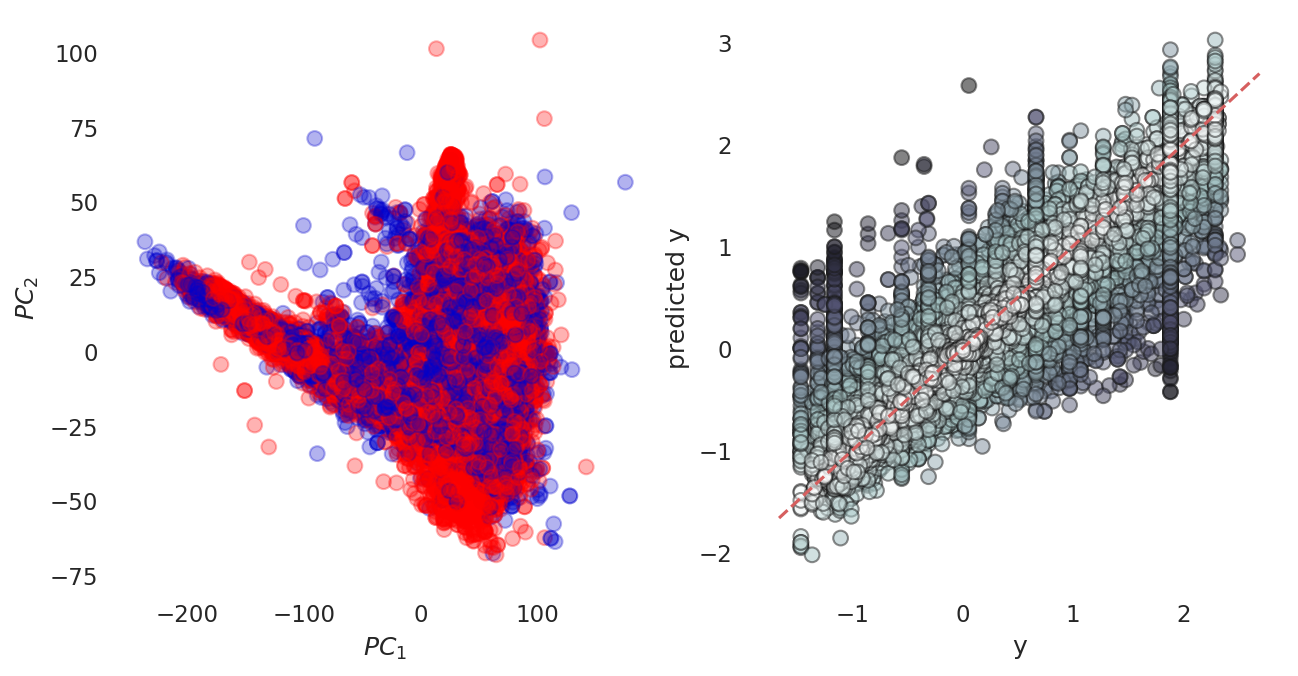

In [109]:
X=np.copy(X_raw)
y_tot=np.vstack((alpha, cn, packing, x, e_form)).T

i_train, i_test, X_train, X_test, y_train, y_test = train_test_split(
np.arange(X.shape[0]), X, y_tot, train_size=0.8
)

x_scaler = StandardFlexibleScaler(column_wise=False).fit(X)
y_scaler = StandardFlexibleScaler(column_wise=False).fit(y_tot)

# Center total dataset
X = x_scaler.transform(X)
Y = y_scaler.transform(y_tot)

# Center training data
X_train = x_scaler.transform(X_train)
y_train = y_scaler.transform(y_train)

# Center training data
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

pcovr = PCovR(mixing=0.5,
              n_components=n_PC)
pcovr.fit(X,Y)
T = pcovr.transform(X)
yp = pcovr.predict(X)
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(10,5))

ax1.scatter(T[:, 0], T[:, 1], s=50, alpha=0.3, c=magic, cmap = my_c)
ax1.set_xlabel(r"$PC_1$")
ax1.set_ylabel(r"$PC_2$")

ax2.scatter(Y, yp, s=50, alpha=0.5, c=np.abs(Y - yp), cmap='bone_r', edgecolor="k")
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'r--')
ax2.set_xlabel(r"y")
ax2.set_ylabel(r"predicted y")
sns.despine(left=True, bottom=True)

w_i_l=pcovr.pxt_
w_l_i=pcovr.pty_
w_i_p=pcovr.pxy_
var=pcovr.explained_variance_ 
sing=pcovr.singular_values_

print(w_i_p, var)
print(pcovr.score(X_test, y_test))

data = write_input(
    path='../chem/MP_prob.json.gz',
    meta={"name": 'MP pcovr'},
    frames=my_frames,
    properties={
        **{f"PCA_{i+1}": 
            {"target": "structure", 
            "values": T[:, i]} for i in range(n_PC)},
        "magic": {
            "target": "structure",
            "values": magic,
        }, 

         "packing": {
            "target": "structure",
            "values": packing, 
         },
        "alpha": {
            "target": "structure",
            "values": alpha, 
         },
        "x": {
            "target": "structure",
            "values": x, 
         },
        "std_rad": {
            "target": "structure",
            "values": std_ratio, 
         },
        "FCC": {
            "target": "structure",
            "values": fcc, 
         },
        "natoms": {
            "target": "structure",
            "values": natoms, 
         },
         
         "n_species": {
            "target": "structure",
            "values": n_species, 
         },
         "e_form": {
            "target": "structure",
            "values": e_form, 
         },
          "magic probability": {
            "target": "structure",
            "values": prob[:,1], 
         },
    })